**IMPORTING LIBRARIES**

In [1]:
!pip install -q yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import time
print(" Libraries Imported Successfully!\n")

 Libraries Imported Successfully!



**DOWNLOAD REAL TIME STOCK DATA**

In [2]:
ticker = input("Enter the stock ticker (example: TCS.NS, INFY.NS, AAPL): ")

# Download stock data with retry logic
max_retries = 3
retry_delay = 60  # Wait 60 seconds between retries

for attempt in range(max_retries):
    try:
        stock_data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
        stock_data = stock_data[['Close']]
        break  # Exit the loop if download is successful
    except Exception as e:
        if "Rate limited" in str(e) or "429" in str(e):
            print(f"Rate limit reached. Retrying in {retry_delay} seconds... (Attempt {attempt + 1}/{max_retries})")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
            else:
                print("Max retries reached. Please try again later or use cached data.")
                raise  # Re-raise the exception if max retries are reached
        else:
            raise  # Re-raise other exceptions immediately

print(f"\nDownloaded data for {ticker}:\n")
print(stock_data.head())

Enter the stock ticker (example: TCS.NS, INFY.NS, AAPL): TCS.NS
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Downloaded data for TCS.NS:

Price             Close
Ticker           TCS.NS
Date                   
2015-01-01  1072.224854
2015-01-02  1086.503906
2015-01-05  1069.992798
2015-01-06  1030.545776
2015-01-07  1018.372742


**PREPROCESSING THE DATA**

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

X, y = [], []
n_steps = 30  # past 30 days window

for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for CNN
X_images = X.reshape((X.shape[0], 6, 5, 1))

print(f" Preprocessing Done!\n")
print(f"X_images shape: {X_images.shape}")
print(f"y shape: {y.shape}\n")

 Preprocessing Done!

X_images shape: (2437, 6, 5, 1)
y shape: (2437,)



**BUILDING THE MODEL**

In [4]:
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(6, 5, 1)),
    Dropout(0.2),
    Flatten(),
    Dense(30),
    Reshape((30, 1)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

print(" Model Summary:\n")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 5, 4, 32)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        19,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,375 (271.00 KB)

 Trainable params: 69,375 (271.00 KB)

 Non-trainable params: 0 (0.00 B)

**IMPORT REQUIRED LIBARIES FOR MATRICS AND PLOTTING**

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
print("Additional libraries imported successfully!")

Additional libraries imported successfully!


**SPLIT DATA INTO TRAINING AND TESTING SETS**

In [ ]:
train_size = int(len(X_images) * 0.8)
X_train, X_test = X_images[:train_size], X_images[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Data split completed: {train_size} training samples, {len(X_test)} testing samples")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data split completed: 1988 training samples, 498 testing samples
X_train shape: (1988, 6, 5, 1), y_train shape: (1988,)
X_test shape: (498, 6, 5, 1), y_test shape: (498,)


**TRAIN THE MODEL FOR 30 EPOCHS**

In [ ]:
print("\nStarting model training for 30 epochs...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
print("Model training completed!")
print(f"Final training loss (MSE): {history.history['loss'][-1]:.6f}")
print(f"Final validation loss (MSE): {history.history['val_loss'][-1]:.6f}")


Starting model training for 30 epochs...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 4.5343e-04 - loss: 0.0295 - val_accuracy: 0.0020 - val_loss: 0.0012
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 3.1599e-05 - loss: 0.0011 - val_accuracy: 0.0020 - val_loss: 0.0013
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0014 - loss: 0.0011 - val_accuracy: 0.0020 - val_loss: 0.0099
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0011 - loss: 9.8925e-04 - val_accuracy: 0.0020 - val_loss: 0.0028
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 7.3718e-05 - loss: 8.5255e-04 - val_accuracy: 0.0020 - val_loss: 0.0016
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.6011e-04 - loss: 9.2267e-04 - val_accuracy: 0.0020 - val_loss: 0.0033
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 2.0403e-04 - loss: 9.3137e-04 - val_accuracy: 0.0020 - val_loss: 0.0034
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━

**EVALUATE THE MODEL**

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("\nModel evaluation completed!")
print(f"Training Loss (MSE): {train_loss[0]:.6f}")
print(f"Testing Loss (MSE): {test_loss[0]:.6f}")


Model evaluation completed!
Training Loss (MSE): 0.000218
Testing Loss (MSE): 0.004575


**MAKE PREDICTIONS**

In [ ]:
predictions = model.predict(X_test, verbose=0)
print("\nPredictions generated!")
print(f"Number of predictions: {len(predictions)}")
print(f"Sample predictions (first 5, scaled): {predictions[:5].flatten()}")


Predictions generated!
Number of predictions: 498
Sample predictions (first 5, scaled): [0.43898782 0.4415253  0.44481853 0.44966817 0.4529251 ]


**INVERSE TRANSFORM PREDICTION AND ACTUAL VALUES**

In [ ]:
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform([y_test])
print("\nInverse transformation completed!")
print(f"Sample actual prices (first 5): {y_test_actual.T[:5].flatten()}")
print(f"Sample predicted prices (first 5): {predictions[:5].flatten()}")


Inverse transformation completed!
Sample actual prices (first 5): [128.65412903 129.22747803 131.95574951 131.87667847 133.21113586]
Sample predicted prices (first 5): [125.18039 125.78447 126.56846 127.72297 128.49832]


**CALCULATE ADDITIONAL METRICS**

In [ ]:
mae = mean_absolute_error(y_test_actual.T, predictions)
r2 = r2_score(y_test_actual.T, predictions)
print("\nPerformance metrics calculated!")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"{'Model performance is excellent!' if r2 >= 0.9 else 'Model performance may need tuning to reach R² ≥ 0.9.'}")


Performance metrics calculated!
Mean Absolute Error (MAE): 13.5784
R² Score: 0.6622
Model performance may need tuning to reach R² ≥ 0.9.


**CHECK IF LOSS IS DECREASING**

In [ ]:
train_loss_trend = all(history.history['loss'][i] >= history.history['loss'][i+1] for i in range(len(history.history['loss'])-1))
val_loss_trend = all(history.history['val_loss'][i] >= history.history['val_loss'][i+1] for i in range(len(history.history['val_loss'])-1))
print("\nLoss trend analysis completed!")
print(f"Training Loss Decreasing: {'Yes' if train_loss_trend else 'No, loss may be fluctuating.'}")
print(f"Validation Loss Decreasing: {'Yes' if val_loss_trend else 'No, loss may be fluctuating.'}")


Loss trend analysis completed!
Training Loss Decreasing: No, loss may be fluctuating.
Validation Loss Decreasing: No, loss may be fluctuating.


**PLOT TRAINING LOSS**

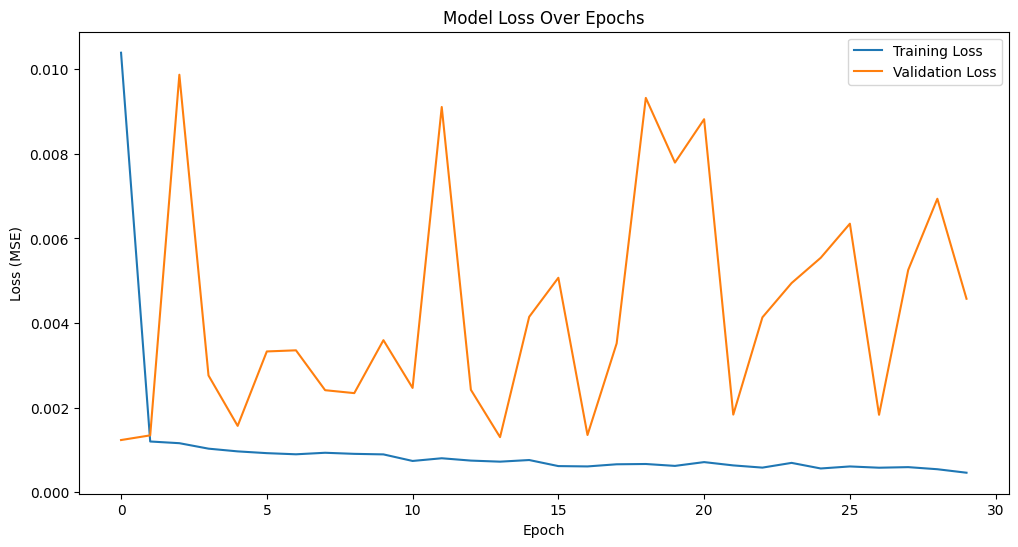


Training and validation loss plot displayed!


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()
print("\nTraining and validation loss plot displayed!")

**PLOT PREDICTION VS ACTUAL**

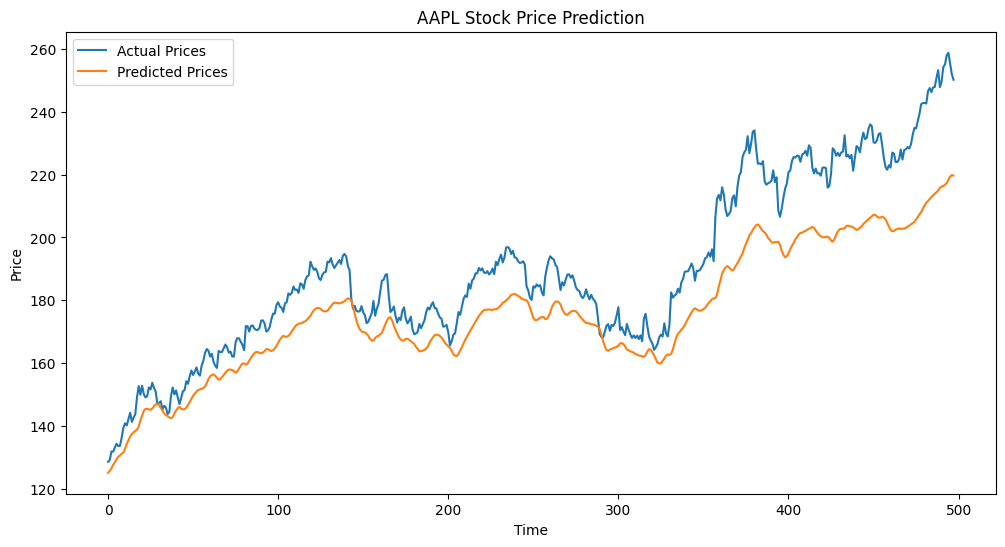

Prediction vs actual prices plot for AAPL displayed!


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual.T, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
print(f"Prediction vs actual prices plot for {ticker} displayed!")